In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import re
from kf import ExtendedKalmanFilter

In [142]:
#  Read data from selected txt file.
with open('slow_rotation_test_data.txt', 'r') as file:

    text = file.read()
    
#  Store data in arrays.
a = [re.split(r'\s', entry) for entry in text.split('\n')]
a = list(filter(lambda x: x != [""] and x!= ["", ""], a))

In [145]:
M_data = [{'X': float(entry[2]), 'Y': float(entry[5]), 'Z': float(entry[8])} for entry in a[::3]]
G_data = [{'X': float(entry[2])*np.pi/180, 'Y': float(entry[5])*np.pi/180, 'Z': float(entry[8])*np.pi/180} for entry in a[1::3]]
A_data = [{'X': float(entry[2]), 'Y': float(entry[5]), 'Z': float(entry[8])} for entry in a[2::3]]
G_array = np.array([list(entry.values()) for entry in G_data])
M_array = np.array([list(entry.values()) for entry in M_data])
A_array = np.array([list(entry.values()) for entry in A_data])

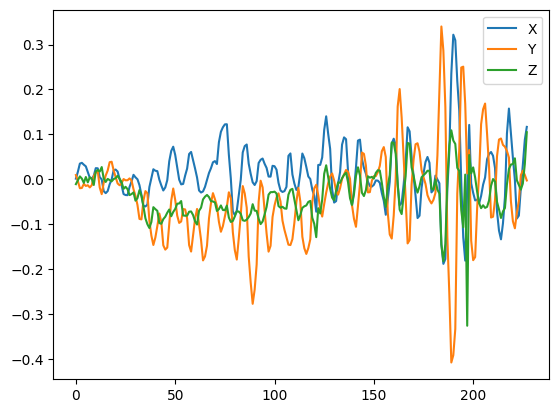

In [149]:
plt.plot(G_array)
plt.legend(['X', 'Y', 'Z'])
# plt.ylim((-0.005, 0.005))

In [6]:
G_stationary_array = G_array[300:]
A_stationary_array = A_array[300:]

In [7]:
def get_covariance_matrix_from_data(data_array=G_stationary_array):

    m = 300
    n, _ = data_array.shape
    mean_array = np.sum(data_array[m:n, :], axis=0)/(n - m)
    variance_array = np.sum((data_array[m:n, :] - mean_array)**2, axis=0)/(n - m - 1)
    
    covariance_matrix = np.eye(3)
    covariance_matrix[0, 0], covariance_matrix[1, 1], covariance_matrix[2, 2] = variance_array
    
    return covariance_matrix, variance_array

In [152]:
x0 = np.array([0, 0, 0])
# P0, variance_array = get_covariance_matrix_from_data(G_stationary_array)
P0 = np.eye(3)*0.01
Q = np.eye(3)*0.01
# R, _ = get_covariance_matrix_from_data(A_stationary_array)
R = np.eye(3)*0.001

In [153]:
# Use the data to simulate.
kf = ExtendedKalmanFilter(x0, P0, Q, R)
m = 0
n, _ = G_array.shape
dt = 0.01

roll_array = []
pitch_array = []
yaw_array = []
P_list = []

for i in range(m, n):
       
    roll_array = np.append(roll_array, kf.roll)
    pitch_array = np.append(pitch_array, kf.pitch)
    yaw_array = np.append(yaw_array, kf.yaw)
    P_list.append(kf.cov)
    
    kf.predict(G_array[i,:], dt)
    
    if i%5 == 0 and i != m:
        
        kf.update(A_array[i, :])
        
P_array = np.array(P_list)

In [ ]:
# Plot roll over time.
plt.plot(roll_array)
plt.plot(roll_array + 2*np.sqrt(P_array[:, 0, 0]), 'r')
plt.plot(roll_array - 2*np.sqrt(P_array[:, 0, 0]), 'r')

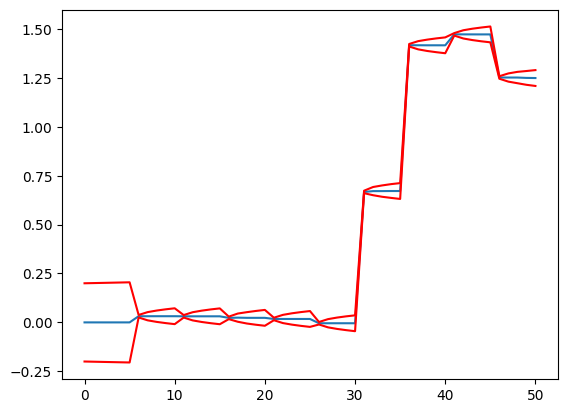

In [139]:
# Plot pitch over time.
plt.plot(pitch_array)
plt.plot(pitch_array + 2*np.sqrt(P_array[:, 1, 1]), 'r')
plt.plot(pitch_array - 2*np.sqrt(P_array[:, 1, 1]), 'r')
# plt.plot(G_array[300:, 1])